# Contenuti

- [Esercitazione MLP](#Esercitazione-MLP)
- [Import](#Import)
- [Dataset](#Dataset)
    - [Le feature utilizzate](#Le-feature-utilizzate)
    - [Caricamento](#Caricamento)
    - [Creazione di train e validation set](#Creazione-di-train-e-validation-set)
- [Import di TensorFlow 2.x](#Import-di-TensorFlow-2.x)
- [Definizione del modello](#Definizione-del-modello)
- [Addestramento](#Addestramento)
- [Esercizio](#Esercizio)
- [Test](#Test)

# Esercitazione MLP
Nell'esercitazione odierna si applicherà una rete *Multilayer Perceptron* (MLP) a un problema di classificazione di tracce audio in cui viene pronunciata una singola cifra (da 0 a 9, in italiano). L'obiettivo è quello di classificare la traccia audio in modo da predire:
- A) la cifra che viene pronunciata (digit recognition). 
- B) la persona che l'ha pronunciata (speaker recognition).

Sul problema A lavoreremo insieme durante la lezione. Il problema B sarà oggetto della competizione (CodaLab).

Per questa esercitazione si farà uso del framework **TensorFlow** (versione 2.x) e di alcune funzionalità messe a disposizione dalla libreria Scikit-learn.

Nel corso dell'esercitazione si dovrà definire l'architettura di una rete neurale in grado di risolvere il problema di classificazione e ottimizzare il suo training (in modo da massimizzare l’accuratezza sul dataset fornito).
Infine si dovrà misurare l'accuratezza ottenuta (utilizzando la soluzione trovata in precedenza) sul dataset di test (scaricabile dal sito del corso) per verificarne l’effettiva capacità di generalizzazione.

# Import
Per prima cosa è necessario eseguire l'import delle librerie utilizzate durante l'esecitazione.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import os
import time
import IPython
from ml_visualization import plot_confusion_matrix

# Dataset

Il dataset è composto dalle tracce audio raccolte da 31 persone (grazie a tutti coloro che hanno contribuito!). Ciscuna persona ha registrato 10 tracce ripetendo i dieci digit in 4 sessioni diverse:
- 1 - Ambiente silenzioso (condizioni ottimali)
- 2 - Ambiente silenzioso (mattina poco dopo risveglio)
- 3 - Ambiente rumoroso (ad esempio all'esterno con traffico)
- 4 - Con rumore di fondo tipo TV o radio

Il training set contiene le tracce delle sessioni 1 e 4, per un totale di 620 pattern (2 x 31 x 10). Il test set contiene le tracce delle sessioni 2 e 3, per un totale di 620 pattern (2 x 31 x 10). Il dataset è fornito sotto forma di blob NumPy.

Non utilizzeremo i file audio grezzi perchè le reti MLP non sono in grado di gestire efficacemente dati multidimensionali di tale complessità. Pertanto sono state pre-estratte feature "compatte" come descritto nella cella seguente.

## Le feature utilizzate

Il dataset consiste in un insieme di feature estratte dalle tracce audio. In particolare sono rese disponibili le MFCC, Chroma, Mean of Mel spectrogram, Spectral Contrast e Tonnetz.

Tra le feature più utilizzate per il riconoscimento del parlato troviamo le **MFCC (Mel Frequency Cepstral Coefficients)**. Si tratta di una rappresentazione particolarmente adatta per il riconoscimento vocale in quanto condensa le informazioni della traccia originale cercando di estrarre le informazioni utilizzate dal sistema uditivo umano. Hanno il grande pregio di essere feature molto compatte e per questo particolarmente indicate per poter essere processate dai comuni algoritmi di Machine Learning.

Per poter comprendere il contenuto delle MFCC è necessario prima di tutto comprendere come lo Spettrogramma di Mel viene calcolato ([qui una spiegazione semplificata](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53)). 

![title](MelSpectrogram.png)

A partire dallo Spettrogramma di Mel è molto semplice ottenere le *MFCC* attraverso un'ulteriore trasformata coseno che decorrela i coefficienti dello spettrogramma ([spiegazione semplificata](https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040)).


Oltre alle MFCC sono anche disponibili altre feature che potrebbero rivelarsi utili ai fini della classificazione delle tracce audio. Ogni pattern del dataset è un vettore composto da 173 feature *floating point*. Il vettore è così suddiviso:

- Features [0:20): MFCC
- Features [20:32): Chroma (https://en.wikipedia.org/wiki/Chroma_feature)
- Features [32:160): Media dello Spettrogramma di Mel
- Features [160:167): Spectral Contrast ([paper](http://hcsi.cs.tsinghua.edu.cn/Paper/Paper02/200218.pdf))
- Features [167:173): Tonnetz ([paper](http://rose.ofai.at/~martin.gasser/papers/oefai-tr-2006-13.pdf))

Ai fini dell'esercitazione non è richiesta la conoscenza teorica della composizione delle feature in questione. Tuttavia si consideri la possibilità di usarne solo alcune.

## Caricamento
Il training set viene fornito sotto forma di un unico file "audio_ml2122_train.npy" contenente sia le feature che le etichette di classe delle tracce audio. La procedura per il caricamento del dataset è fornita nella cella seguente.

In [4]:
# Caricamento del dataset
train_dataset = np.load('DBs/AudioDigits_ML21_22/audio_ml2122_train.npy')
print('Shape del dataset:', train_dataset.shape)

# Posizione delle etichette (per il problema A si usa digit_column, per il problema B speaker_column)
digit_column = 173
speaker_column = 174

# Le ultime due colonne sono lasciate alle etichette (digit e speaker)
dataset_x = train_dataset[:, :-2].astype(np.float32)
dataset_y = train_dataset[:, digit_column].astype(int)   
print('Shape del training set (X):', dataset_x.shape)
print('Shape del training set (Y):', dataset_y.shape)

# Etichette di classe
digit = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

print('Numero di pattern per ogni classe:')
class_labels, count = np.unique(dataset_y, return_counts=True)
for label, n_patterns in zip(class_labels, count):
    print(digit[label], '->', n_patterns, 'patterns')

Shape del dataset: (620, 175)
Shape del training set (X): (620, 173)
Shape del training set (Y): (620,)
Numero di pattern per ogni classe:
zero -> 62 patterns
one -> 62 patterns
two -> 62 patterns
three -> 62 patterns
four -> 62 patterns
five -> 62 patterns
six -> 62 patterns
seven -> 62 patterns
eight -> 62 patterns
nine -> 62 patterns


Il test set viene fornito in due file separati: "audio_ml2122_test_no_labels.npy" (comune ai problemi A e B) e "audio_ml2122_test_digit_labels.npy" contenente le etichette per il problema A. Ovviamente le etichette per il problema B non sono date.

La procedura per il caricamento del test set è fornita nella cella seguente.

In [ ]:
# Caricamento del dataset (test)
test_x = np.load('DBs/AudioDigits_ML21_22/audio_ml2122_test_no_labels.npy')
test_y = np.load('DBs/AudioDigits_ML21_22/audio_ml2122_test_digit_labels.npy')

print('Shape del dataset X:', test_x.shape)
print('Shape del dataset Y:', test_y.shape)

# Conversione dei dati (test)
test_x = test_x.astype(np.float32)
test_y = test_y.astype(int)
print('Shape del test set (X):', dataset_x.shape)
print('Shape del test set (Y):', dataset_y.shape)

Shape del dataset X: (620, 173)
Shape del dataset Y: (620,)
Shape del test set (X): (620, 173)
Shape del test set (Y): (620,)


## Creazione di train e validation set
Il successivo passo consiste nell'ottenere un training set e un validation set. A tal fine viene utilizzata la funzione [**train_test_split(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) messa a disposizione da Scikit-learn.

È possibile scegliere la percentuale di pattern da utilizzare nel validation set modificando il parametro *validation\_size*.

La cella seguente esegue anche una normalizzazione dei dati utilizzando [**StandardScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) fornito da Scikit-learn. Questa normalizzazione si rivela essere particolarmente utile quando si intende utilizzare delle reti neurali.

In [6]:
# Split del dataset in training e validation
validation_size = 0.2
train_x, valid_x, train_y, valid_y = train_test_split(dataset_x, dataset_y, test_size=validation_size, random_state = 1234)

print('Training dataset contains', len(train_x), 'patterns')
print('Validation dataset contains', len(valid_x), 'patterns')

print('Training dataset shape', train_x.shape, train_y.shape)
print('Validation dataset shape', valid_x.shape, valid_y.shape)

# Applica nomralizzazione con StandardScaler di scikit-learn
scaler = StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)
valid_x = scaler.transform(valid_x)

# Applica normalizzazione anche al test
test_x = scaler.transform(test_x)

Training dataset contains 496 patterns
Validation dataset contains 124 patterns
Training dataset shape (496, 173) (496,)
Validation dataset shape (124, 173) (124,)


# Import di TensorFlow 2.x

Il prossimo passo è quello di caricare il framework TensorFlow. Per questa esercitazione verrà utilizzata la versione più recente (2.x).

Nel momento stesso in cui viene eseguito l'import, TensorFlow controlla se nel PC è presente un dispositivo (come una GPU dedicata) in grado di velocizzare i calcoli solitamente impiegati per l'addestramento e uso di reti neurali. Oltre ad eseguire l'import di Tensor Flow la prossima cella mostrerà anche i dispositivi rilevati. Se non è presente alcun acceleratore verrà mostrata solamente la CPU.

Si noti come TensorFlow, se non configurato diversamente, utilizzerà automaticamente tutti gli acceleratori presenti nel sistema. In questo caso, per evitare di appesantire sistemi dotati di più GPU, utilizziamo la variabile di ambiente *CUDA\_VISIBLE\_DEVICES* per rendere utilizzabile solo la prima GPU. Se si imposta *CUDA\_VISIBLE\_DEVICES = -1*, anche in presenza di GPU, si forza TensorFlow a usare la sola CPU.

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Nasconde messaggi di debug
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # Rende visibile solo la GPU 0

# Import TensorFlow 2.x
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.python.client import device_lib
print('Tensorflow Version', tf.__version__)

# Mostra i dispositivi disponibili

print ("\nHardware Devices:")
print (device_lib.list_local_devices())

Tensorflow Version 2.10.0

Hardware Devices:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11925467504353656783
xla_global_id: -1
]


# Definizione del modello

Una volta eseguito l'import di TensorFlow è possibile procedere a definire il modello (l'architettura della rete) che si intende utilizzare. Il modo più semplice è quello di utilizzare l'API **Keras** che permette di definire una rete neurale semplicemente descrivendo la struttura e l'ordine degli strati di cui è composta.

In particolare per questa esercitazione verranno utilizzati solamente *layer* di tipo *fully connected*. In Keras questi layer sono implementati nella classe [**Dense**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

I principali parametri sono rappresentati:

1. Dal numero di valori di output, impostato dal primo parametro. Si noti come l'ultimo layer deve obbligatoriamente avere un numero di output pari al numero di classi del problema da risolvere (in questo caso 10).
2. Dalla funzione di attivazione. Sono disponibili diverse funzioni (si veda la documentazione). La funzione di attivazione per l'ultimo layer dovrà sempre essere *softmax*.

La classe **Sequential** ([tutorial](https://www.tensorflow.org/guide/keras/sequential_model)) permette di gestire automaticamente il collegamento tra i successivi layer della rete permettendo allo sviluppatore di non dover specificare la *shape* delle attivazioni intermedie.

Nota: Keras è anche disponibile come API di alto livello installabile in maniera *indipendente dal framework* e in grado di sfruttare motori di esecuzione diversi da TensorFlow (ad esempio *MXNet* di Amazon). Google tuttavia ha ben integrato Keras in TF 2.x, per cui si consiglia sempre di riferirsi alla documentazione di *tf.keras* disponibile [qui](https://www.tensorflow.org/api_docs/python/tf/keras/) e non a quella presente sul sito *keras.io*.

Di seguito è definita la funzione che verrà richiamata per costruire il modello. Questo, una volta creato tramite *Sequential*, viene "compilato". La funzione *compile(...)* lega il modello all'ottimizzatore e alla funzione di *loss* da utilizzare per l'addestramento. A queste si aggiungono eventuali metriche da utilizzare per verificare la bontà del modello (in questo caso, essendo un problema di classificazione, l'accuratezza).

In [8]:
# Procedura di creazione del modello
def build_model(n_features):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='tanh', input_shape=[n_features]),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.SGD(0.005)
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Addestramento

La seguente cella mostra il codice richiesto per istanziare e addestrare il modello. Il modello parte da pesi scelti casualmente dal framework. Il metodo [**.summary(...)**](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) permette di visualizzare al struttura della rete, compreso il numero dei parametri addestrabili.

Verificare che il numero di parametri addestrabili sia quello atteso dato il numero di livelli e neuroni (tipica domanda all'esame).

In questo esempio viene anche mostrato come utilizzare la tecnica di *early stopping*, implementata in TensorFlow nella classe [**EarlyStopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping). Questa permette di terminare prematuramente l'addestramento se la variabile monitorata (*val\_loss*, ovvero la loss sul validation set) non diminuisce per il numero specificato di iterazioni.

Si noti come il metodo **.fit(...)** sia molto simile a quello visto nell'API offerta da Scikit-learn.

In [11]:
model = build_model(train_x.shape[1])
model.summary()

n_epochs = 100
minibatch_size = 8

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start = time.time()

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y),
                    epochs=n_epochs, batch_size=minibatch_size, shuffle=True,
                    verbose=0, callbacks=[early_stop, tfdocs.modeling.EpochDots(report_every=10, dot_every=1)])

print('\nTraining MLP completato in %.2f s.' % (time.time() - start))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                11136     
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 11,786
Trainable params: 11,786
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.1069,  loss:2.4960,  val_accuracy:0.0645,  val_loss:2.5705,  
..........
Epoch: 10, accuracy:0.4355,  loss:1.6470,  val_accuracy:0.2177,  val_loss:2.1499,  
..........
Epoch: 20, accuracy:0.6210,  loss:1.3407,  val_accuracy:0.2500,  val_loss:2.0394,  
..........
Epoch: 30, accuracy:0.6895,  loss:1.1578,  val_accuracy:0.3065,  val_loss:1.9940,  
..........
Epoch: 40, accuracy:0.7198,  loss:1.0270,  val_accuracy:0.3306,  v

La funzione *.fit(...)* restituisce l'andamento del valore numerico di diverse metriche classiche. Analizzare visivamente questi valori può essere utile per individuare eventuali anomalie e per correggere sia la struttura del modello che gli iperparametri dell'ottimizzatore.

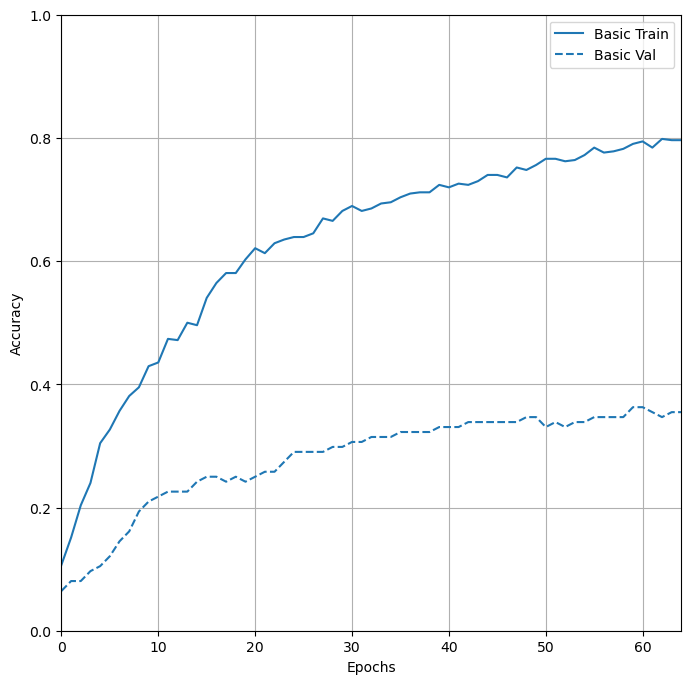

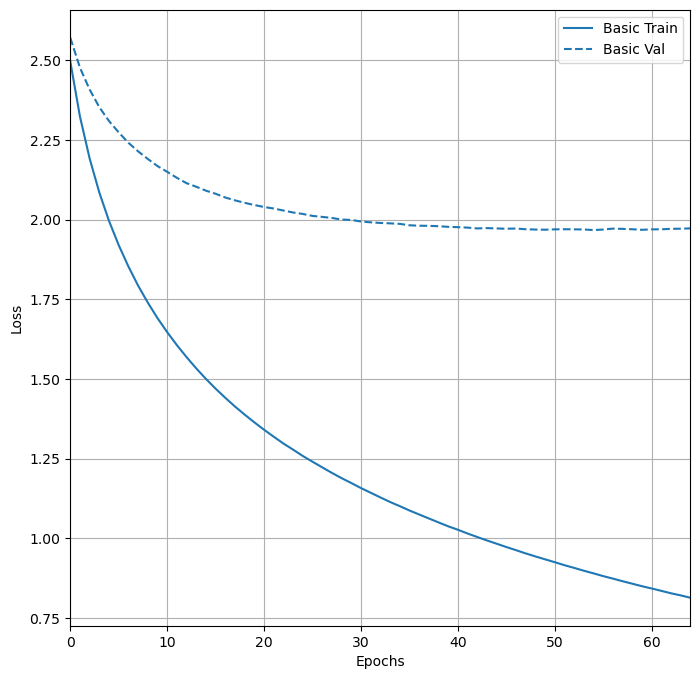

In [12]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=0)

plotter.plot({'Basic': history}, metric="accuracy")
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.show()

plotter.plot({'Basic': history}, metric="loss")
plt.ylabel('Loss')
plt.show()

Infine, **una volta ottenuta una configurazione ritenuta ottimale**, sarà possibile verificare la soluzione anche sul test set. Nella cella seguente verrà visualizzata l'accuratezza e la Confusion Matrix del modello sul test set:

20/20 [==============================] - 0s 1ms/step
Accuratezza sul test set: 35.483870967741936 %


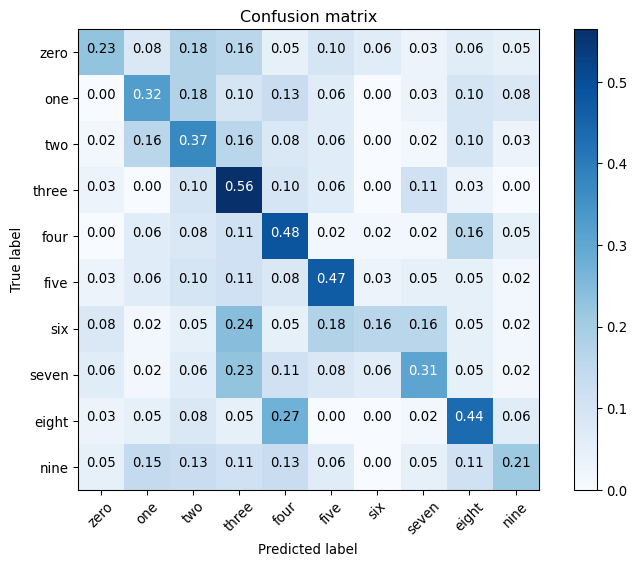

In [13]:
test_predictions = model.predict(test_x)
test_predictions = test_predictions.argmax(axis=-1)

print('Accuratezza sul test set:', accuracy_score(test_y, test_predictions) * 100, '%')

plot_confusion_matrix(test_y, test_predictions, classes=['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'])

# Esercizio

L'obiettivo è quello di massimizzare l'accuratezza di classificazione per il **problema di riconoscimento dello speaker** (problema B, 31 classi), di cui non sono date le etichette. Il dataset di test è lo stesso usato per il problema di riconoscimento delle cifre. 

- Si consideri la possibilità di **modificare l'architettura della rete** aggiungendo o rimuovendo layer e modificando il numero di neuroni per ogni livello;
- **Modificare la funzione di attivazione** può potenzialmente migliorare il modello. Si noti come, a seconda della funzione utilizzata, potrebbe essere necessario adattare il modo con cui sono generati i pesi casuali iniziali. La generazione casuale dei pesi è controllata tramite il parametro *kernel\_initializer* dei layer *Dense*;
- È possibile **modificare l'ottimizzatore** (e i relativi iperparametri) utilizzando uno di quelli disponibili in Keras ([qui la lista completa](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers));
- Applicare una **regolarizzazione L1 o L2** può prevenire alcuni problemi di under o overfitting e di convergenza. A tal fine si consideri l'uso del parametro *kernel\_regularizer* dei layer *Dense*;
- È possibile utilizzare **uno *scheduler* del Learning Rate** tra quelli disponilibi in Keras ([qui la lista completa](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules)). Nella documentazione dei vari scheduler sono presenti semplici esempi che mostrano come utilizzarli.
- Si consiglia di definire un codice con cui **eseguire una Cross Validation efficace**. Nel libro di A. Geron, "Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent System" è spiegato come "wrappare" modelli di Keras in modo da rendere possibile l'uso della funzionalità di CrossValidation e GridSearch di Scikit-learn;
- Ricordate che una volta definiti gli iperparametri e la procedura ottimale di training può convenire utilizzare tutto il training set per l'addestramento finale (senza escludere porzione di validation).

Ai fini dell'esercizio valgono le seguenti regole:

- Non è possibile aggiungere al training set dati esterni, inclusi i dati del test set;
- Non si possono utilizzare le etichette (del problema A) per la risoluzione del problema B.
- Sì può eseguire una data augmentation inserendo feature derivate (anche se non è semplice visto il formato di input). Può essere utilizzato un sottoinsieme delle feature.
- Nel modello potranno essere usati solamente layer *Dense*.
- È possibile usare un multiclassificatore, ma solo combinando più reti neurali (e non altri classificatori visti in precedenza come SVM e RandomForest);

In [3]:
# Caricamento del dataset
train_dataset = np.load('DBs/AudioDigits_ML21_22/audio_ml2122_train.npy')
print('Shape del dataset:', train_dataset.shape)

speaker_column = 174

# Le ultime due colonne sono lasciate alle etichette (digit e speaker)
dataset_x = train_dataset[:, :-2].astype(np.float32)
dataset_y = train_dataset[:, speaker_column].astype(int)   
print('Shape del training set (X):', dataset_x.shape)
print('Shape del training set (Y):', dataset_y.shape)
dataset_y

Shape del dataset: (620, 175)
Shape del training set (X): (620, 173)
Shape del training set (Y): (620,)


array([ 6, 16, 22, 12, 13, 29,  3, 16, 12, 22, 17, 10,  2, 28,  8,  3, 26,
       18, 12, 14, 30, 16,  5, 10, 11, 12,  6, 27, 16,  7,  5, 12, 26, 25,
       22, 30, 25,  2,  1, 17, 23,  4, 30, 30, 29, 27, 22,  2,  8, 28,  0,
       23, 12, 14,  3,  3, 24, 19,  8,  9, 11,  3,  9, 29, 27,  9, 19,  8,
       10, 17, 25, 30, 23,  9, 12, 23,  6, 30,  5,  8, 22, 12, 14, 21, 20,
       23, 16, 15, 27,  0, 10,  3,  4, 28, 29, 28, 21, 22,  8, 13, 13, 14,
       18, 27, 14, 15, 15,  1,  6,  9, 15, 14,  3, 16, 13,  1, 10,  8, 10,
       28, 12,  1, 25, 17, 25,  1,  3,  2, 16, 23, 24, 13, 29,  4, 26, 15,
       28, 16, 18, 28,  2, 15, 27,  9, 29, 15, 24, 25, 14, 16, 25, 23,  6,
        0,  5, 15, 14, 30,  6, 28, 13, 18,  1, 22, 13, 29,  7, 30, 19,  1,
       11, 17, 26, 15, 26, 30,  9, 28, 23, 23,  1, 17, 17, 19, 13, 27, 24,
        0, 21,  1, 25, 27,  2,  5,  7, 25, 20, 21,  6,  5,  0,  5, 27, 20,
        9, 21, 28, 28, 11,  2,  1, 24,  7, 11, 30,  7, 28, 21, 30,  5,  5,
       26, 29,  3, 12, 16

In [4]:
# Split del dataset in training e validation
validation_size = 0.2
train_x, valid_x, train_y, valid_y = train_test_split(dataset_x, dataset_y, test_size=validation_size, random_state = 1234)

print('Training dataset contains', len(train_x), 'patterns')
print('Validation dataset contains', len(valid_x), 'patterns')

print('Training dataset shape', train_x.shape, train_y.shape)
print('Validation dataset shape', valid_x.shape, valid_y.shape)

# Applica nomralizzazione con StandardScaler di scikit-learn
scaler = StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)
valid_x = scaler.transform(valid_x)


Training dataset contains 496 patterns
Validation dataset contains 124 patterns
Training dataset shape (496, 173) (496,)
Validation dataset shape (124, 173) (124,)


In [5]:
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf

np.random.seed(42)  # NumPy seed
tf.random.set_seed(42)  # TensorFlow random seed

speaker_model = tf.keras.Sequential([
    # Input layer with more units
    tf.keras.layers.Dense(128, activation='relu', input_shape=[train_x.shape[1]]),

    # Hidden layers
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(31, activation='softmax')  # Match number of classes
])

optimizer = Adam(learning_rate=0.001)
speaker_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])


In [6]:
speaker_model.summary()

n_epochs = 500
minibatch_size = 32

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start = time.time()

speaker_history = speaker_model.fit(train_x, train_y, validation_data=(valid_x, valid_y),
                    epochs=n_epochs, batch_size=minibatch_size, shuffle=True,
                    verbose=0, callbacks=[early_stop, tfdocs.modeling.EpochDots(report_every=10, dot_every=1)])

print('\nTraining MLP completato in %.2f s.' % (time.time() - start))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               22272     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 31)                1023      
                                                                 
Total params: 33,631
Trainable params: 33,631
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.0907,  loss:3.3555,  val_accuracy:0.0806,  val_loss:3.2778,  
..........
Epoch: 10, accuracy:0.9899,  loss:0.1760,  val_accuracy:0.8468,  val_loss:0.6735,  
.....

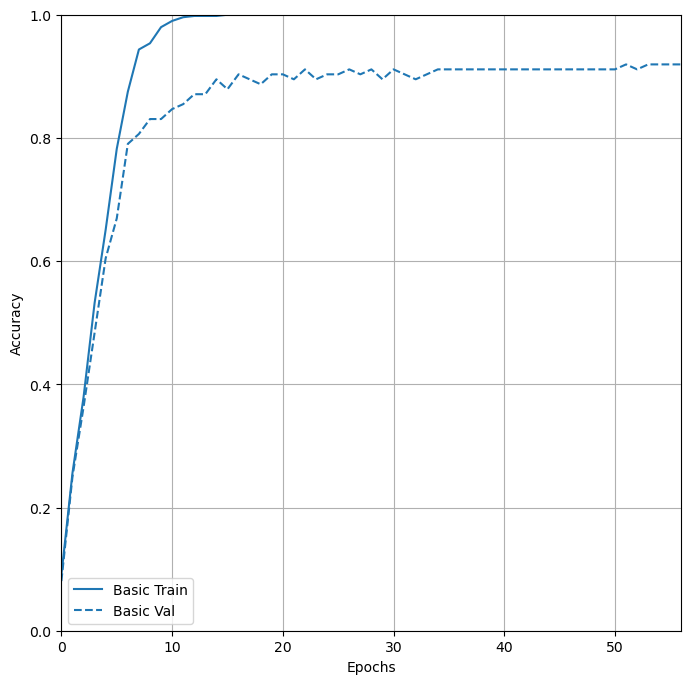

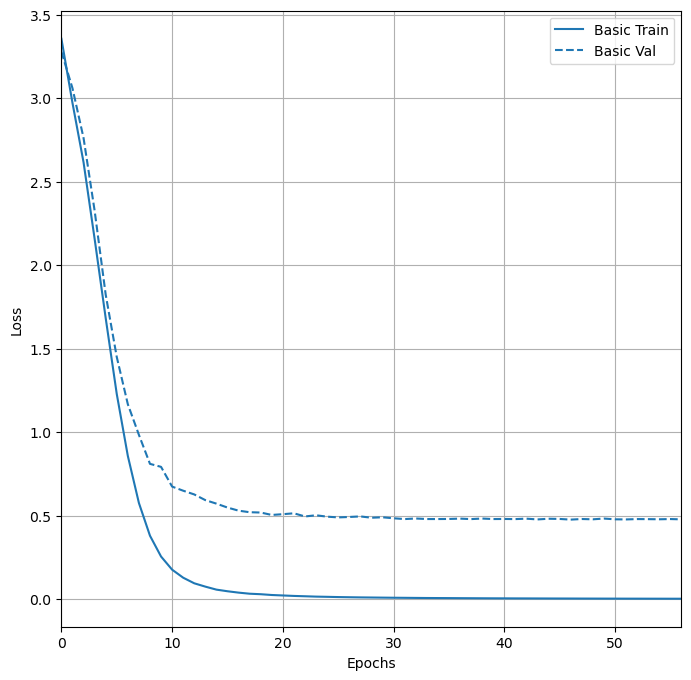

In [7]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=0)

plotter.plot({'Basic': speaker_history}, metric="accuracy")
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.show()

plotter.plot({'Basic': speaker_history}, metric="loss")
plt.ylabel('Loss')
plt.show()

In [8]:
test_predictions = speaker_model.predict(valid_x)
test_predictions = test_predictions.argmax(axis=-1)

print('Accuratezza sul validation set:', accuracy_score(valid_y, test_predictions) * 100, '%')
test_predictions

4/4 [==============================] - 0s 2ms/step
Accuratezza sul validation set: 91.12903225806451 %


array([ 3, 23, 19, 16, 27, 30, 19, 22,  6,  6, 26,  8, 29, 14, 13,  4, 29,
        5, 18, 26,  4,  1, 15, 10, 13, 12, 24, 20, 14,  7,  3, 27, 12, 28,
       16,  6, 23,  4, 11, 10,  1,  9, 13,  8, 12, 23, 10,  9, 23,  6, 14,
       21, 13, 30, 19, 25,  5,  1,  8,  3,  3, 21, 28, 20, 27, 29,  9, 19,
       29, 10,  2,  2, 24,  9, 26,  4, 20, 29,  9, 21,  2,  0, 21, 28,  0,
       11,  9, 11, 30,  6, 25,  4,  6, 15,  6, 16, 13, 23, 17, 20, 21, 15,
        1, 20, 16,  3,  9, 30, 27, 17, 30, 15,  4, 13,  9, 25,  4, 14, 17,
       10, 20, 22, 23, 16], dtype=int64)

# Test
Si addestri il modello desiderato utilizzando l'architettura, l'ottimizzatore e i relativi iperparametri trovati nell'esercizio precedente. Il codice contenuto nella cella seguente userà tale modello per predire la classe dei pattern del dataset di test. Le classi predette verranno salvate su un file di testo che dovrà essere caricato sul sito della competizione per misurarne l'accuratezza.
Le procedure utilizzate per caricare i dataset e per addestrare la rete desiderata dovranno essere riportate nella cella seguente. Ai fini della competizione si ricorda che nel file .zip dovrà essere inclusa anche una cartella "Codice" contenente una copia di questo notebook e degli script Python utilizzati.

In [9]:
# Caricamento del dataset di training
train_dataset = np.load('DBs/AudioDigits_ML21_22/audio_ml2122_train.npy')

# Conversione dei dati
dataset_x = train_dataset[:,:-2].astype(np.float32)
dataset_y = train_dataset[:, speaker_column].astype(int)
train_x, valid_x, train_y, valid_y = train_test_split(dataset_x, dataset_y, test_size=0.2, random_state = 1234)

# Caricamento del dataset di test
test_dataset = np.load('DBs/AudioDigits_ML21_22/audio_ml2122_test_no_labels.npy')

# Conversione dei dati
test_x = test_dataset.astype(np.float32)

# Scaling dei dati ...
scaler = StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)
valid_x = scaler.transform(valid_x)
test_x = scaler.transform(test_x)

# Addestramento del modello
np.random.seed(42)  # NumPy seed
tf.random.set_seed(42)  # TensorFlow random seed

speaker_model_test = tf.keras.Sequential([
    # Input layer with more units
    tf.keras.layers.Dense(128, activation='relu', input_shape=[train_x.shape[1]]),

    # Hidden layers
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(31, activation='softmax')  # Match number of classes
])

optimizer = Adam(learning_rate=0.001)
speaker_model_test.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

speaker_model_test.summary()

n_epochs = 500
minibatch_size = 32

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start = time.time()

speaker_history_test = speaker_model_test.fit(train_x, train_y, validation_data=(valid_x, valid_y),
                                                epochs=n_epochs, batch_size=minibatch_size, shuffle=True,
                                                verbose=0, callbacks=[early_stop, tfdocs.modeling.EpochDots(report_every=10, dot_every=1)])

print('\nTraining MLP completato in %.2f s.' % (time.time() - start))

predictions = speaker_model_test.predict(test_x)
predictions = predictions.argmax(axis=-1)
np.savetxt('Es7Predictions.txt', predictions.astype(int), fmt='%i')
print('Ok')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               22272     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 31)                1023      
                                                                 
Total params: 33,631
Trainable params: 33,631
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.0504,  loss:3.3829,  val_accuracy:0.0887,  val_loss:3.2469,  
..........
Epoch: 10, accuracy:0.9859,  loss:0.2262,  val_accuracy:0.8226,  val_loss:0.6922,  
...